In [38]:
from astropy.io import fits
from astropy.constants import c, k_B
import matplotlib.pyplot as plt
from astropy.coordinates import Angle
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import numpy.ma as ma
from matplotlib.colors import SymLogNorm, LogNorm
import matplotlib.ticker as ticker
import cmasher as cmr  # thanks Bron for a hint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=120)

In [24]:
from copy import deepcopy
import warnings

## Reading and reprojecting images

In [3]:
from reproject import reproject_interp

In [4]:
def galnamelc(n: str):
    return n.replace("_", '').lower()

In [5]:
galaxyname = 'NGC_3621'

In [6]:
from argparse import Namespace

In [7]:
def readdata(name, irtype='irac1', suf=''):
    if suf != "":
        suf = '_' + suf
    return Namespace(
        hI = fits.open(f"{name}_NA_MOM0_THINGS.FITS")[0],
        hI_v = fits.open(f"{name}_NA_MOM1_THINGS.FITS")[0],
        IR = fits.open(f"{galnamelc(name)}_{irtype}_gauss7p5{suf}.fits")[0],
        CO = fits.open(f"{galnamelc(name)}_12m+7m+tp_co21_2as_broad_mom0.fits")[0],
        CO_v = fits.open(f"{galnamelc(name)}_12m+7m+tp_co21_2as_mom1wprior.fits")[0],
    )

In [8]:
def fixHheader(h):
    w = WCS(h)
    w = w.dropaxis(3).dropaxis(2)
    return w.to_header()

In [9]:
def reproject_data(o, pivot):
    array, _ = reproject_interp(o.IR, pivot)
    o.IR.data = array
    
    array, _ = reproject_interp(o.CO, pivot)
    o.CO.data = array
    
    array, _ = reproject_interp(o.CO_v, pivot)
    o.CO_v.data = array
    
    newhead = fixHheader(o.hI.header)
    newhead['BUNIT'] = o.hI.header['BUNIT'] # need later
    newhead['RESTFREQ'] = o.hI.header['RESTFREQ'] # need later
    o.hI = fits.PrimaryHDU(data=o.hI.data[0][0], header=newhead)
    array, _ = reproject_interp(o.hI, pivot)
    o.hI.data = array

    newhead = fixHheader(o.hI_v.header)
    newhead['BUNIT'] = "km s-1" # need later
    o.hI_v = fits.PrimaryHDU(data=o.hI_v.data[0][0]/1000, header=newhead)
    array, _ = reproject_interp(o.hI_v, pivot)
    o.hI_v.data = array

In [10]:
o = readdata(galaxyname, irtype='w1', suf='interpol')

In [11]:
pivot = o.IR.header
reproject_data(o, pivot)

In [12]:
o.PA = 343.8 #deg
o.inc = 65.8 #deg
o.vsys = 724.3 #km/s
o.ra_c = Angle('11h18m16.3').to(u.deg).value
o.dec_c = -32.81192 #deg, <-- this one is from LEDA
o.dist = 7.06 * u.Mpc
o.BMAJ = 4.4300E-03 *u.deg # from history of VLA header
o.BMIN = 2.8437E-03 *u.deg

In [13]:
o.hI_v.data -= o.vsys
o.CO_v.data -= o.vsys

In [14]:
def polarcoords(o: Namespace, data, header, returndecalso=False):
    x, y = np.indices(np.shape(data))
    w = WCS(header, naxis=2)
    ra, dec = w.all_pix2world(x,y, 0)
    ra -= o.ra_c
    dec -= o.dec_c
    ra *= np.cos(np.radians(o.dec_c))
    PA_w = 180-o.PA
    ra_rot = ra*np.cos(np.radians(PA_w)) - dec*np.sin(np.radians(PA_w))
    dec_rot = ra*np.sin(np.radians(PA_w)) + dec*np.cos(np.radians(PA_w))
    ra_scaled = ra_rot
    dec_scaled = dec_rot / np.cos(np.radians(o.inc))
    r = np.sqrt(ra_scaled**2 + dec_scaled**2)
    theta = np.arctan2(dec_scaled, ra_scaled)
    if returndecalso:
        return r, theta, ra_scaled, dec_scaled
    else:
        return r, theta

## Display

In [302]:
def makeplots(o: Namespace):
    m0cmap, velcmap = cmr.sunburst_r, cmr.prinsenvlag_r
    fig = plt.gcf()
    cbarargs = dict(
        fraction=0.05, pad = 0.04,
        extend = 'max', drawedges=False, format=ticker.FormatStrFormatter("%g")
    )
    grid = (2, 3)
    clevels = [0.01, 0.06, 0.1, 0.2, 0.5]
    for im, index, cmap, l, opts, in [
        (o.IR, 1, m0cmap, "IR $M_0$", dict(norm=LogNorm(vmin=2e-3))),
        (o.CO, 3, m0cmap, "CO $M_0$", dict(vmax=40, vmin=0)),
        (o.CO_v, 6, velcmap, "CO $M_1$", {}),
        (o.hI, 2, m0cmap, r"$\rm H_I$ $M_0$", {}),
        (o.hI_v, 5, velcmap, r"$\rm H_I$ $M_1$", {})
    ]:
        ax = plt.subplot(*grid, index, projection=WCS(pivot))
        h = ax.imshow(im.data, origin='lower', cmap=cmap, **opts)
        cbar = fig.colorbar(h, **cbarargs, label=im.header['BUNIT'])
        ax.text(0.03,0.03, l, bbox=dict(boxstyle="round", fc="w", alpha=0.9),
                horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        r,_ = polarcoords(o, im.data,pivot)
        ax.contour(r, colors='gray', levels=clevels)

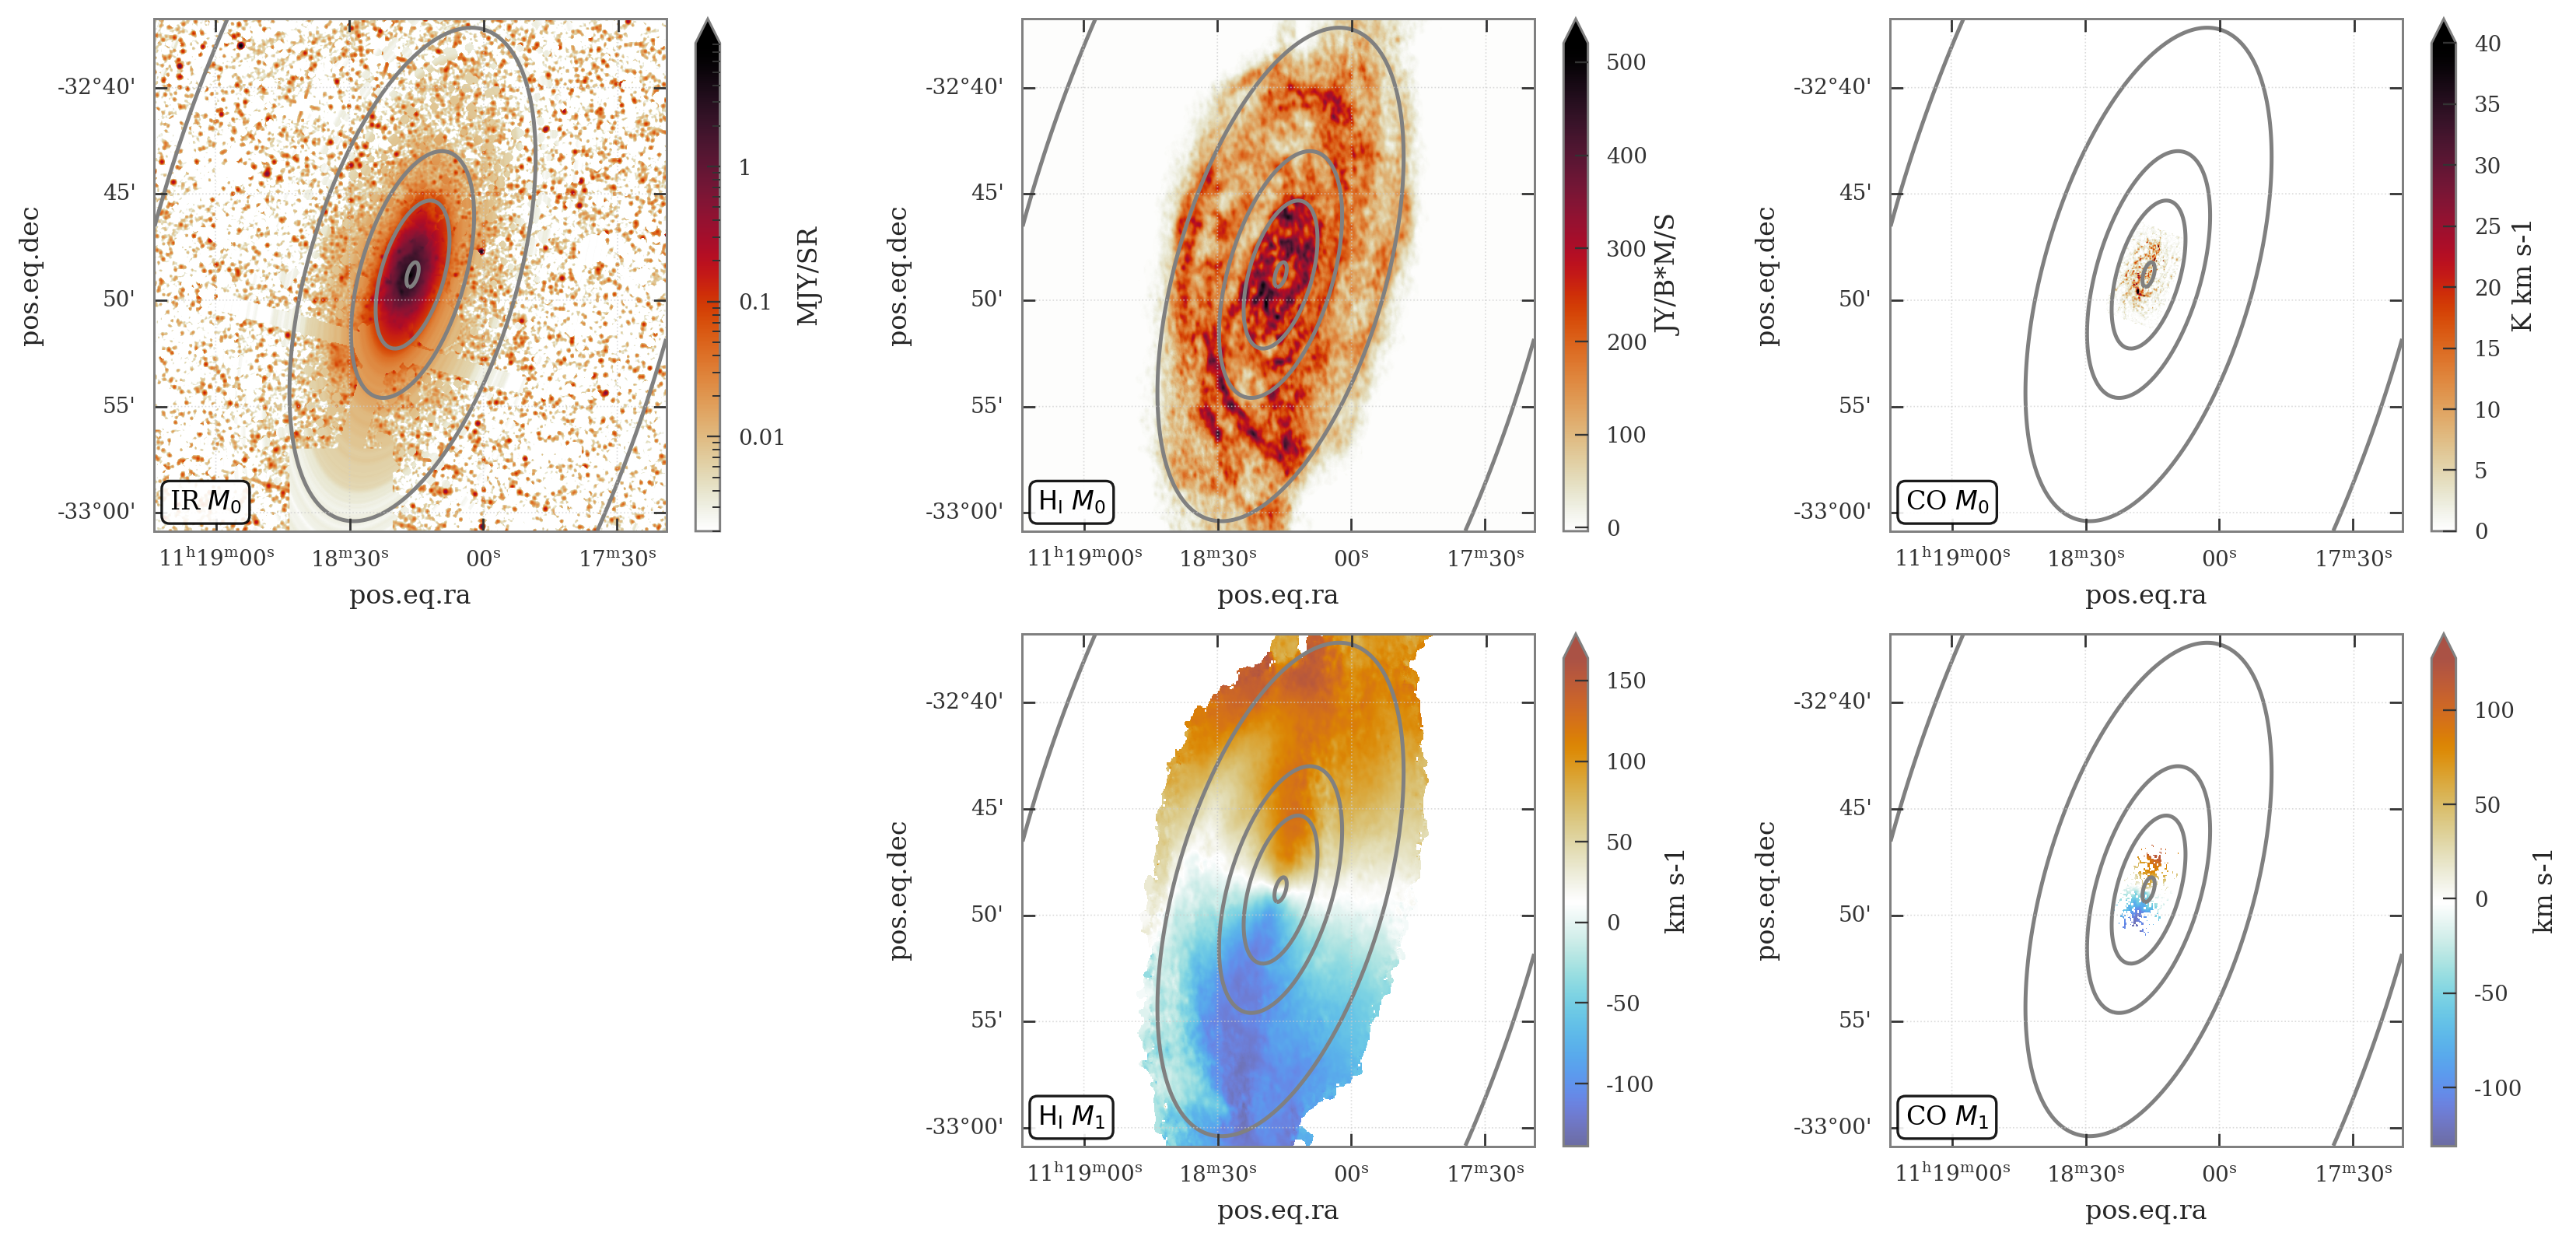

In [303]:
plt.figure(figsize=(17,8))
makeplots(o)
#plt.savefig(f"{galaxyname}_polarcontours.png", bbox_inches='tight')

<br>

## Intensity profiles

quick lookup at radii values 

Text(0, 0.5, 'I (MJY/SR)')

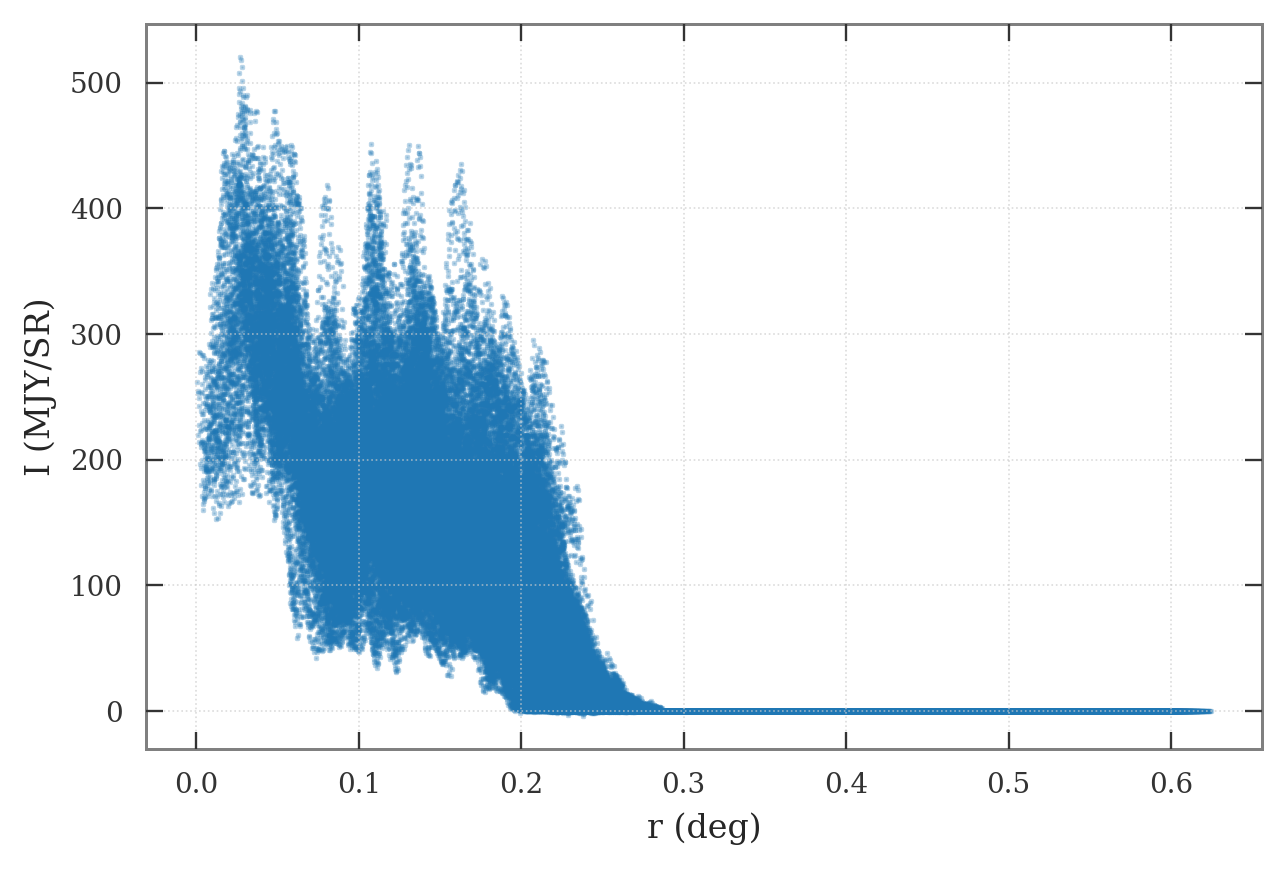

In [17]:
data, h = o.hI.data, pivot
r, theta = polarcoords(o, data, h)

plt.scatter(r.flatten(), data.flatten(), s=0.5, marker=',', alpha=0.3)
plt.xlabel("r (deg)")
plt.ylabel(f"I ({h['BUNIT']})")

In [18]:
from astropy.stats import sigma_clipped_stats

Manual binning of the data, greater control of averaging inside a bin

In [177]:
import numpy.ma as ma

In [115]:
from functools import wraps
from dict_hash import dict_hash

In [119]:
dict_hash(dict(zip(range(3), [np.array([4,3,5]),3,4])))

-4454428469648534448

In [147]:
arrayhasher = xxhash.xxh64()

In [159]:
makebinscache = dict()

def makebins(x, rng, Nbins):
    arrayhasher.update(r)
    h = arrayhasher.intdigest() + hash(rng) + hash(Nbins)
    arrayhasher.reset()
    if h not in makebinscache:
        binedges = np.linspace(*rng, Nbins+1)
        dg = np.digitize(x, binedges) # the slowest thing
        dg -= 1  # hmmm, weird idea to make indices start from 1
        xx = (binedges[:-1] + binedges[1:])/2
        makebinscache[h] = xx, dg
    return makebinscache[h]

In [278]:
binmaskscache = dict()

def bindata(
    var, data, limits, Nbins = 100,
    masknans=False, nanfilling=None, 
    selection_mask = True,
    aggfunc = lambda data, mask: (np.nanmedian(data[mask]), np.nanstd(data[mask])), 
    digitized_var = None,
):
    xx, dg = makebins(var, limits, Nbins)
    if masknans or nanfilling is not None:
        data = ma.MaskedArray(data, mask=np.isnan(data), fill_value=nanfilling)
        if nanfilling is not None:
            data = data.filled(nanfilling)
    
    with warnings.catch_warnings(): 
        # we can safely ignore masked-to-nan conversion warnings
        warnings.simplefilter("ignore")
        
        # ok, no way, we need to write a loop here
        yy_list = []
        
        for i in range(Nbins):
            v, err = aggfunc(data, (dg == i) & selection_mask)
            yy_list.append([v, err])
        yy, yy_err = np.array(yy_list, dtype=float).T    
    return xx, yy, yy_err

In [21]:
def radconv(unit, x):
    return (np.radians(x)*o.dist).to(unit).value

In [22]:
def intensity2K(data, head):
    beam_area = (o.BMAJ * o.BMIN/4) * np.pi / np.log(2)
    freq = head['RESTFREQ'] *u.Hz
    equiv = u.brightness_temperature(freq)
    return (data * u.Jy/beam_area).to(u.K, equivalencies=equiv).value

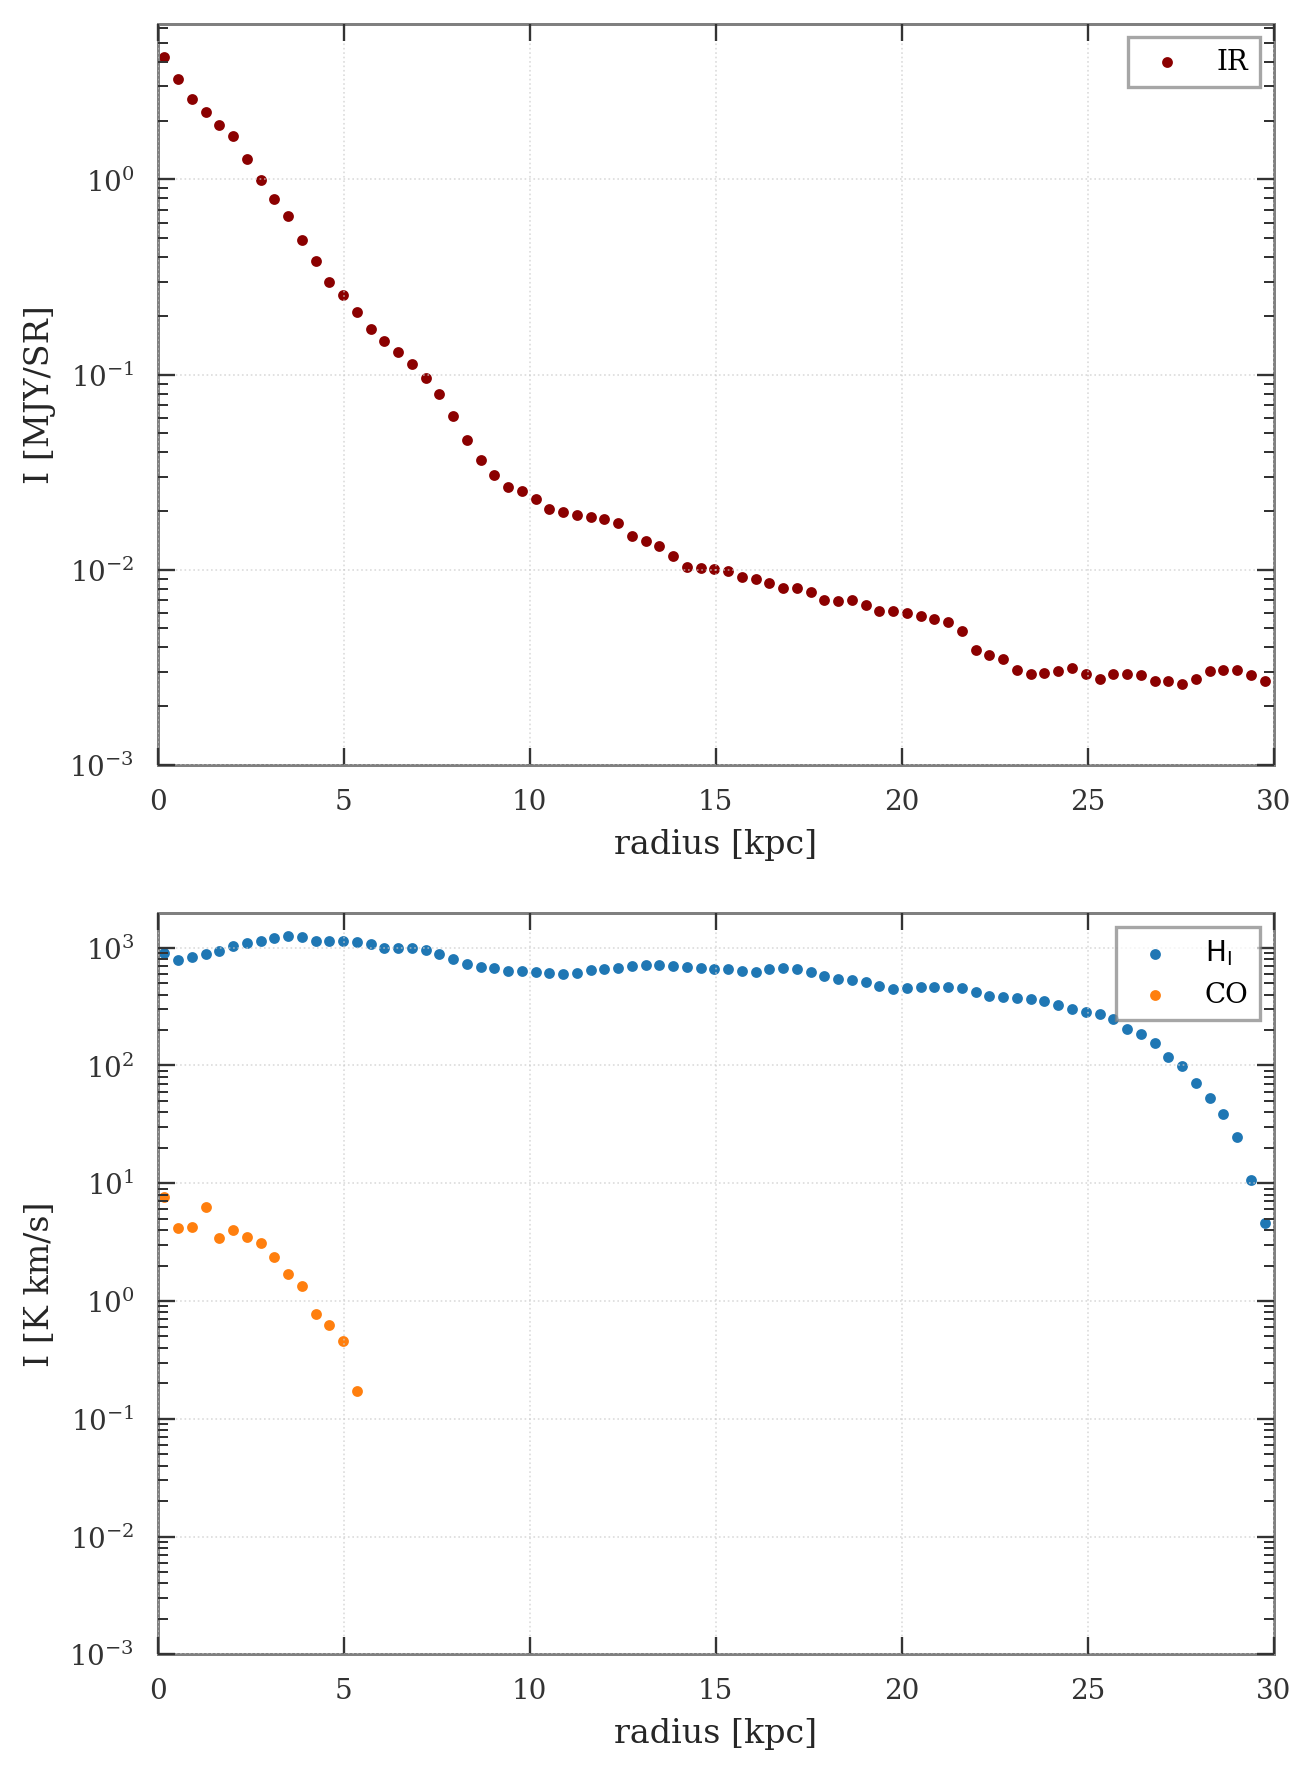

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(6, 9))

# same dims
r, theta = polarcoords(o, o.IR.data, pivot)
xrange = (0, 0.3)

rr, II, _ = bindata(r, o.IR.data, xrange)
ax[0].scatter(radconv(u.kpc, rr), II, s=5, label = 'IR', color='darkred')
ax[0].set_ylabel(f"I [{o.IR.header['BUNIT']}]")

rr, II, _ = bindata(r, o.hI.data, xrange)
ax[1].scatter(
    radconv(u.kpc, rr),
    intensity2K(II, o.hI.header)/1000,  
    s=5, label = r'$\rm H_I$')

rr, II, _ = bindata(r, o.CO.data, xrange, masknans=True, nanfilling=0)

ax[1].scatter(
    radconv(u.kpc, rr),
    II, # no need to convert intensity here
    s=5, label = r'CO')
ax[1].set_ylabel(f"I [K km/s]")

for a in ax:
    a.set_yscale('log')
    a.set_xlabel('radius [kpc]')
    a.set_xlim(0, 30)
    a.set_ylim(1e-3, None)
    a.legend()
fig.savefig('profiles_all.png')

## Computing mass profiles

In [26]:
from astropy.constants import m_p

In [27]:
r, theta = polarcoords(o, o.IR.data, pivot)

In [29]:
rr, II, _ = bindata(r, o.hI.data, xrange, nanfilling=0)
II_corr = intensity2K(II, o.hI.header)/1000

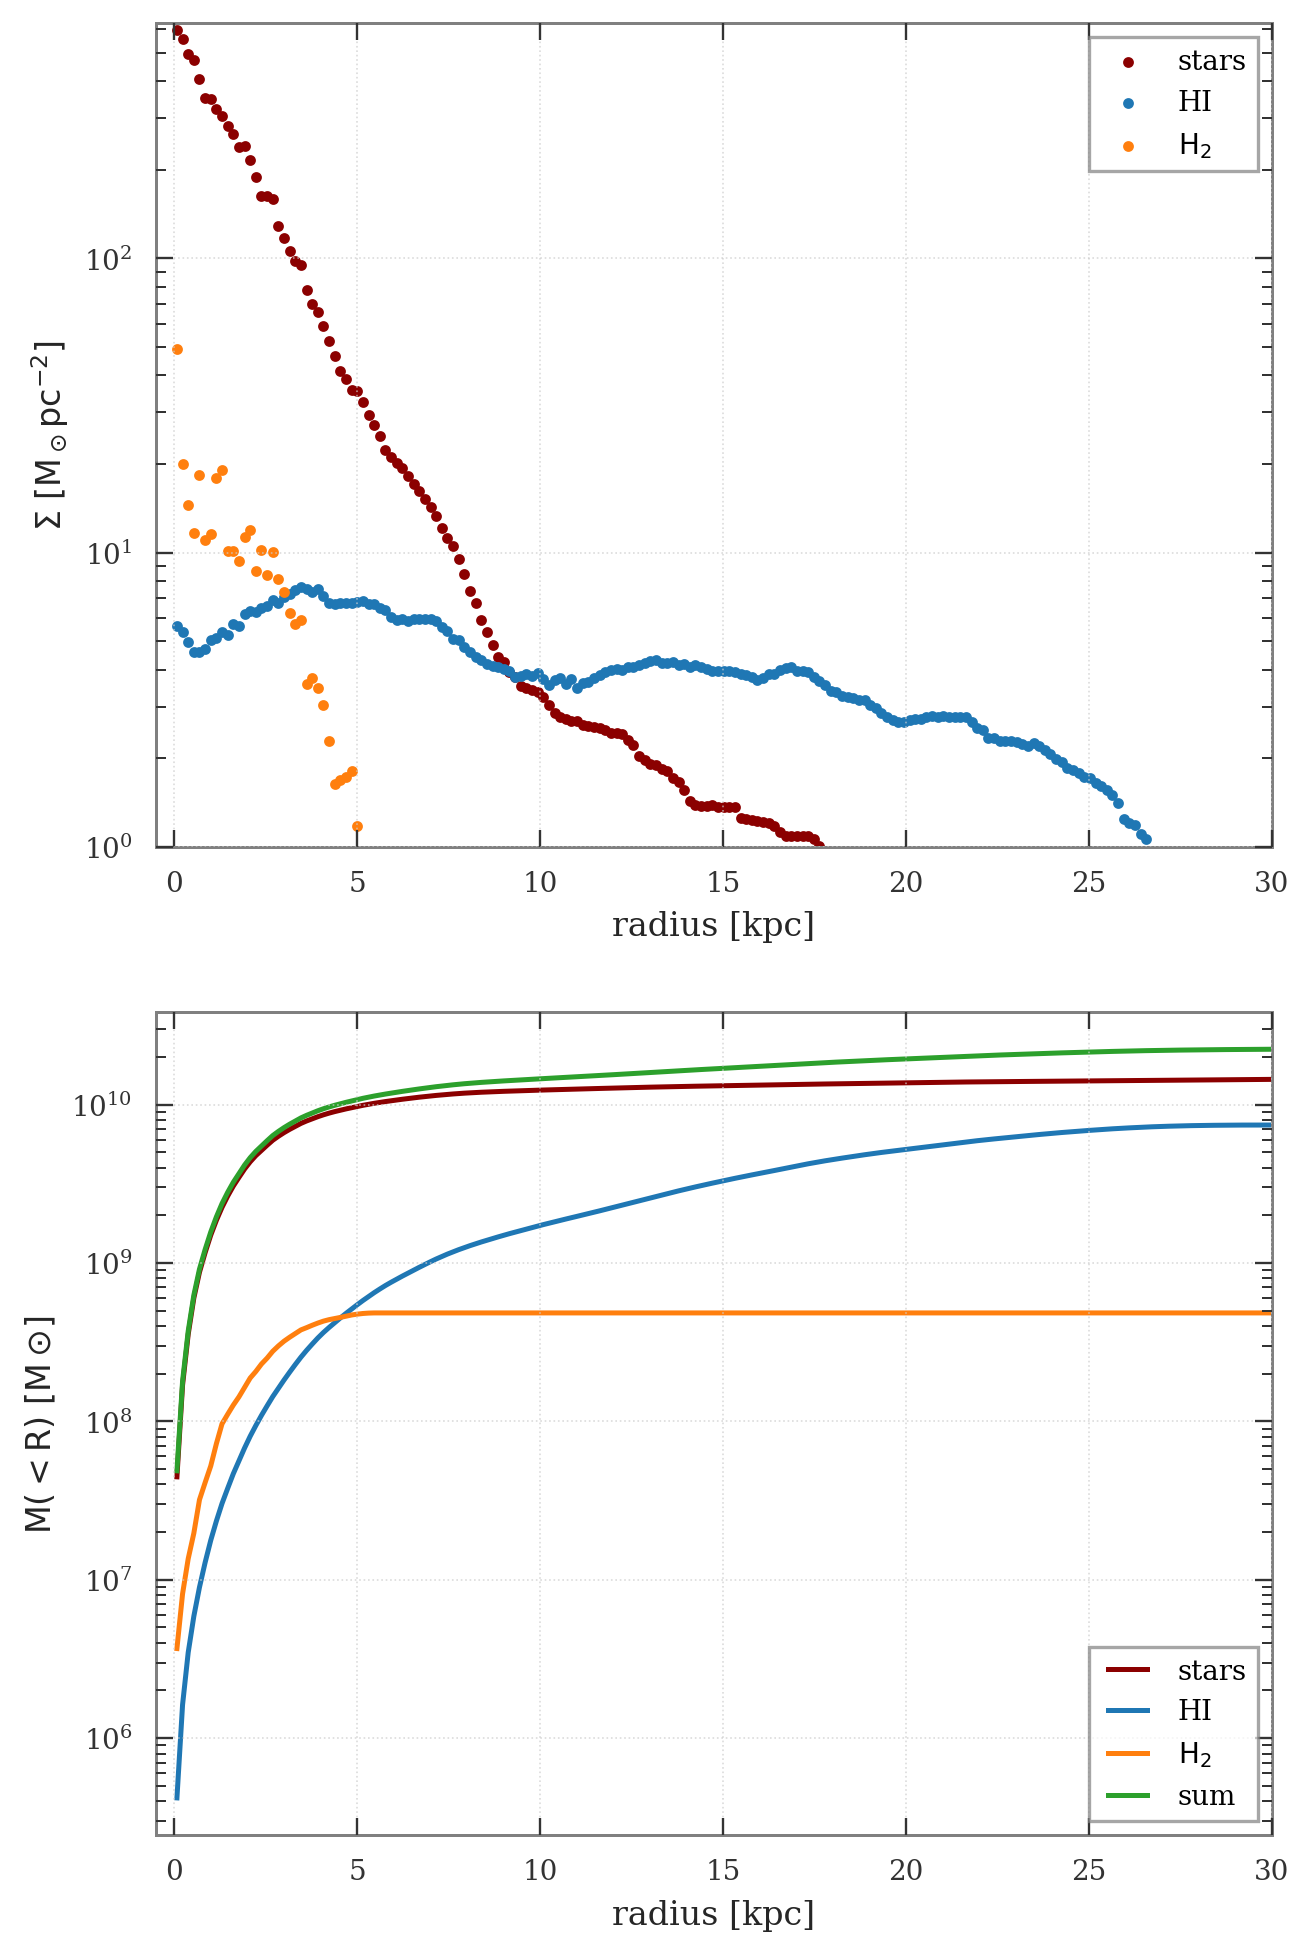

In [277]:
xrange=(0,0.25)
Nbins = 200


fig, ax = plt.subplots(2,1, figsize=(6, 10))
rr, II, _ = bindata(r, o.IR.data, xrange, Nbins=Nbins)
binwidth = rr[1] - rr[0]
mass2light = 0.5

# https://arxiv.org/pdf/2104.07739.pdf
stellar_mass = 330 * (mass2light/0.5) * np.cos(np.radians(o.inc)) * II # now in solmass /pc^2
stellar_mass_c = np.cumsum(stellar_mass*2*np.pi*radconv(u.pc, rr)*(radconv(u.pc, binwidth)))

ax[0].scatter(radconv(u.kpc, rr), stellar_mass, label='stars', color='darkred', s=5)
ax[1].plot(radconv(u.kpc, rr), stellar_mass_c, label='stars', color='darkred')

## atomic gas ##
rr, II, _ = bindata(r, o.hI.data, xrange, Nbins=Nbins)
II_corr = intensity2K(II, o.hI.header)/1000

HIconc = II_corr * 1.823e+18 * u.cm**(-2)*np.cos(np.radians(o.inc))
HImass = (HIconc * m_p).to(u.Msun/u.pc**2).value
HImass_c = np.cumsum(HImass*2*np.pi*radconv(u.pc, rr)*(radconv(u.pc, binwidth)))

ax[0].scatter(radconv(u.kpc, rr), HImass, label='HI', s=5)
ax[1].plot(radconv(u.kpc, rr), HImass_c, label='HI')

## molecular gas ##
rr, II, _ = bindata(r, o.CO.data, xrange, nanfilling=0, Nbins=Nbins)

H2mass = II*6.7*np.cos(np.radians(o.inc))
H2mass_c = np.cumsum(H2mass*2*np.pi*radconv(u.pc, rr)*(radconv(u.pc, binwidth)))

ax[0].scatter(radconv(u.kpc, rr), H2mass, label=r'$\rm H_2$', s=5)
ax[1].plot(radconv(u.kpc, rr), H2mass_c, label=r'$\rm H_2$')

ax[0].set_ylim(1e0)
ax[0].set_ylabel(r'$\Sigma\ [\rm M_\odot pc^{-2}]$')
ax[1].set_ylabel(r'$\rm M (< R) \ [M\odot\!]$')

## sum ##
ax[1].plot(
    radconv(u.kpc, rr), 
    np.nansum([H2mass_c, HImass_c, stellar_mass_c], axis=0),
    label='sum')

for a in ax:
    a.set_yscale('log')
    a.set_xlabel('radius [kpc]')
    a.set_xlim(-0.5, 30)
    a.legend()

#plt.savefig("cmassdensityprofiles.png")

## Radial velocity

In [31]:
from scipy.optimize import curve_fit
import numpy.ma as ma

Make a very simple model for $v(\theta)$

In [161]:
def curvemodel(theta, A):
    return A*np.cos(theta)

In [181]:
def velocity_fitted(theta):
    def closure(data, mask):
        tt, vv, _ = bindata(
            theta, data, (-np.pi, np.pi), Nbins=100,selection_mask=mask,
            aggfunc = lambda data, m: (ma.median(data[m]), 0)  # faster
        )
        # remove NaN's, the optimizer doesn't like them
        nanmask = ~np.isnan(vv)
        try:
            vmax, evmax = curve_fit(curvemodel, tt[nanmask], vv[nanmask])
        except ValueError:
            vmax, evmax = np.nan, [[np.nan]]
        return vmax, evmax[0][0]
    return closure
    

In [223]:
def majoraxis_slice(x, y, width):
    def closure(data, mask):
        # two symmetric spots 
        subset = np.abs(data[mask & (np.abs(y) < width)])
        return ma.median(subset), ma.std(subset)
    return closure

In [290]:
def azimutal_average(theta):
    def closure(data, mask):
        tt, vv, _ = bindata(
            theta, data, (-np.pi, np.pi), Nbins=100, selection_mask=mask,
            aggfunc = lambda data, m: (ma.median(data[m]), 0)  # faster
        )
        sanemask = abs(abs(tt) - np.pi/2) > 0.02
        az_corr = vv[sanemask]/np.cos(tt[sanemask])
        return np.nanmedian(az_corr), np.nanstd(az_corr)
    return closure

In [294]:
def azimutal_average_weighted(theta, weight):
    def closure(data, mask):
        Nbins = 60
        tt, vv, _ = bindata(
            theta, data, (-np.pi, np.pi), Nbins=Nbins, selection_mask=mask,
            aggfunc = lambda data, m: (np.nanmean(data[m]), 0)  # faster
        )
        tt, II, _ = bindata(
            theta, weight, (-np.pi, np.pi), Nbins=Nbins, selection_mask=mask,
            aggfunc = lambda data, m: (np.nanmean(data[m]), 0)  # faster
        )
        az_corr = vv/np.cos(tt)
        sanemask = abs(abs(tt) - np.pi/2) > 0.02
        nanmask = sanemask #& (~np.isnan(vv)) & (~np.isnan(II))
        return np.nansum(az_corr[nanmask]*II[nanmask])/np.nansum(II[nanmask]), np.nan
    return closure

In [301]:
radconv(u.kpc, 0.06)

7.393214711447979

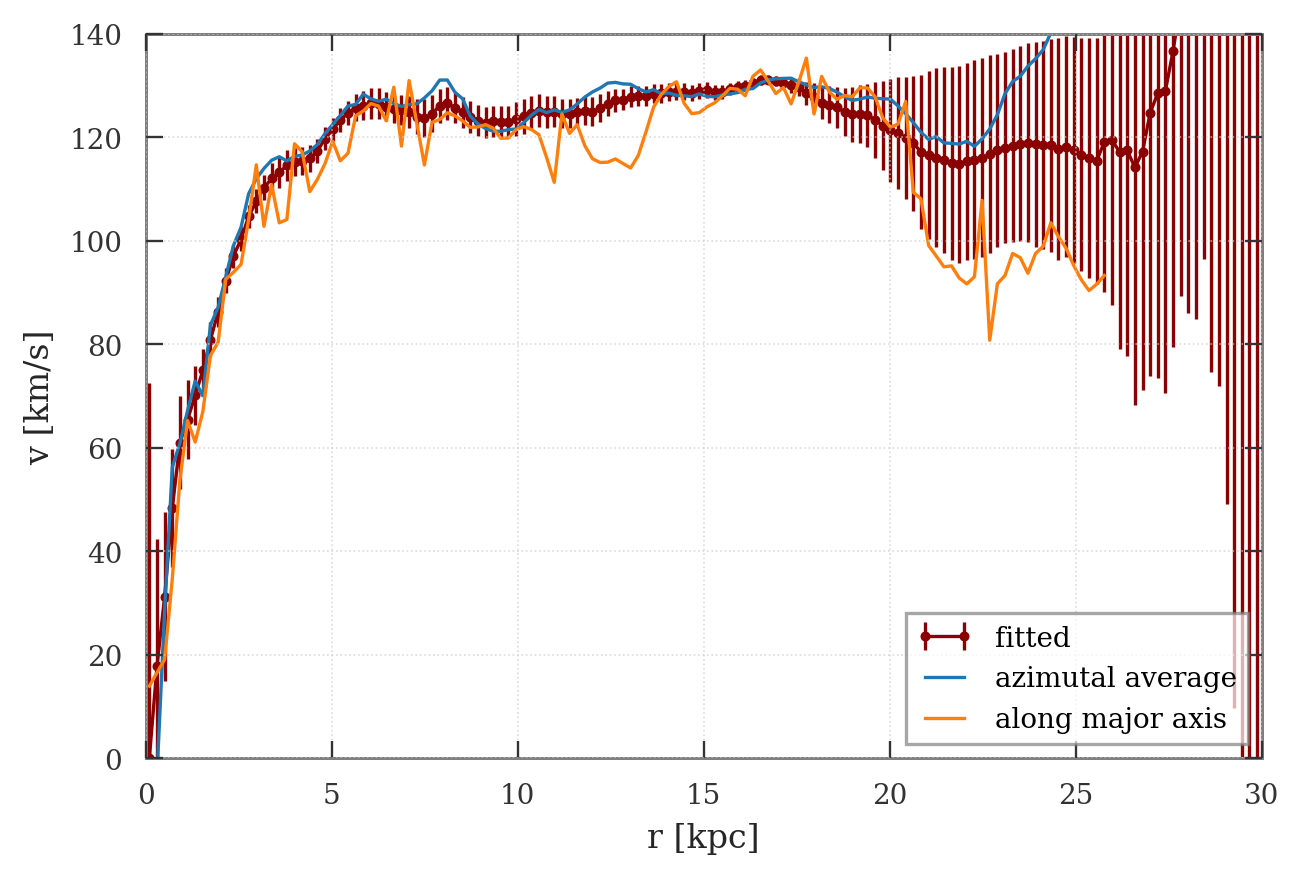

In [304]:
r, theta, x, y = polarcoords(o, o.hI_v.data, pivot, returndecalso=True)

Nbins = 150
xrange = (0, 0.25)


rr, vv, e_vv = bindata(r, o.hI_v.data, xrange, Nbins=Nbins,
                       aggfunc=velocity_fitted(theta))
plt.errorbar(radconv(u.kpc, rr), vv/np.sin(np.radians(o.inc)),
             marker='o', ms=2, elinewidth=1, lw=1, yerr=e_vv, color='darkred', 
             label='fitted')


rr, vv, e_vv = bindata(r, o.hI_v.data, xrange, Nbins=Nbins,
                       aggfunc=azimutal_average_weighted(theta, o.hI.data))
plt.errorbar(radconv(u.kpc, rr), vv/np.sin(np.radians(o.inc)), 
             marker='o', ms=0, elinewidth=1, lw=1, label='azimutal average')


rr, vv, e_vv = bindata(r, o.hI_v.data, xrange, Nbins=Nbins,
                       aggfunc=majoraxis_slice(x, y, 0.005))
plt.errorbar(radconv(u.kpc, rr), vv/np.sin(np.radians(o.inc)), 
             marker='o', ms=0, elinewidth=1, lw=1, label='along major axis')


plt.ylim(0, 140)
plt.xlim(0, 30)
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()
plt.savefig('rotation_curves.png')

Plain old good loops version for a future experiments

In [271]:
Nbins = 100

data = o.hI_v.data
intdata = o.hI.data
r, theta, x, y = polarcoords(o, o.hI_v.data, pivot, returndecalso=True)

majaxisvels = []
azavergvels = []
vels = []
vels2 = []
evels = []

rr_edges = np.linspace(0, 0.25, Nbins+1)
rr_dg = np.digitize(r, rr_edges)
rr_dg -= 1  

rr = (rr_edges[:-1] + rr_edges[1:])/2

tt_edges = np.linspace(-np.pi, np.pi, Nbins+1)
tt_dg = np.digitize(theta, tt_edges)
tt_dg -= 1  


tt = (tt_edges[:-1] + tt_edges[1:])/2

ma_data = ma.MaskedArray(data, mask = np.isnan(data))
ma_data_II = ma.MaskedArray(intdata, mask = np.isnan(intdata))



for j in range(Nbins):
    rmask = rr_dg == j

    # binning thetas
    vv = []
    II = []
    for i in range(Nbins):
            tmask = (tt_dg == i) & rmask
            vv.append(ma.mean(ma_data[tmask]))
            II.append(ma.mean(ma_data_II[tmask]))
    vv = np.array(vv)
    II = np.array(II)
    
        
    sanemask = abs(abs(tt) - np.pi/2) > 0.02
    az_corr = vv[sanemask]/np.cos(tt[sanemask])

    vels.append(np.nanmedian(az_corr))
    vels2.append(np.nansum(II[sanemask]*vv[sanemask]/np.cos(tt[sanemask])) / np.nansum(II[sanemask]))
    evels.append(np.nanstd(az_corr))
    
vels = np.array(vels)
#     majaxisvels.append(np.mean(data[
#         (rr_left[j] < x) & (rr_right[j] > x) & (np.abs(y) < 0.02)
#     ]))

<ipython-input-271-ef9e30825145>:41: UserWarning: Warning: converting a masked element to nan.
  vv = np.array(vv)
<ipython-input-271-ef9e30825145>:42: UserWarning: Warning: converting a masked element to nan.
  II = np.array(II)


In [269]:
rr = np.array(rr)
majaxisvels = np.array(majaxisvels)

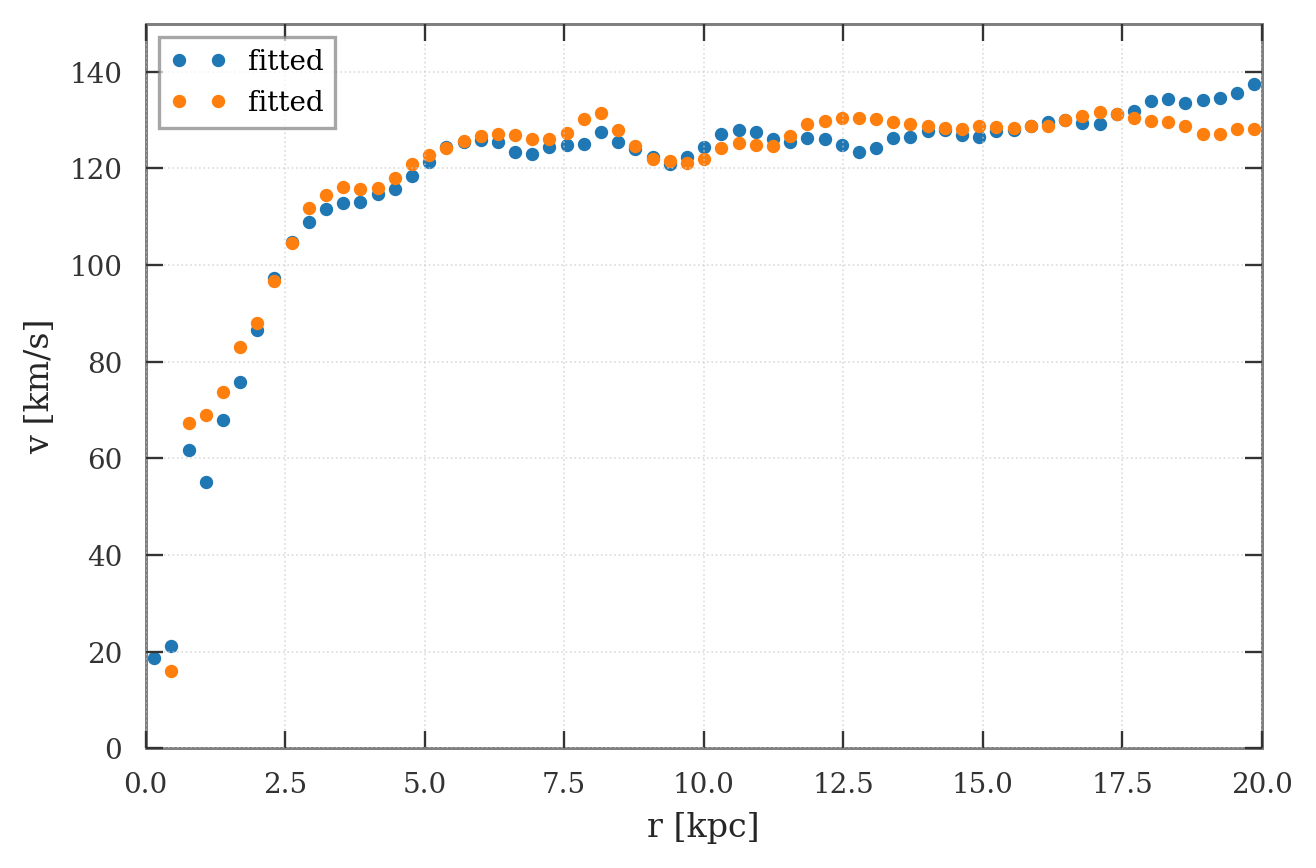

In [272]:
plt.errorbar((np.radians(rr)*o.dist).to(u.kpc).value, vels/np.sin(np.radians(o.inc)), marker='o', ms=3, elinewidth=1, lw=0, label='fitted')
plt.errorbar((np.radians(rr)*o.dist).to(u.kpc).value, vels2/np.sin(np.radians(o.inc)), marker='o', ms=3, elinewidth=1, lw=0, label='fitted')

#plt.errorbar((np.radians(rr)*o.dist).to(u.kpc).value, majaxisvels/np.sin(np.radians(o.inc)), marker='o', ms=3, elinewidth=1, lw=0, label='along major axis')

plt.ylim(0, 150)
plt.xlim(0, 20)
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()
#plt.savefig('rotcurve_experiment_inc_ax.png')

In [171]:
3.2*1.36

4.352